<a href="https://colab.research.google.com/github/01PrathamS/PyTorch_Exercises/blob/main/ovr_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d iamsouravbanerjee/animal-image-dataset-90-different-animals
!unzip -q /content/animal-image-dataset-90-different-animals.zip


100% 654M/656M [00:19<00:00, 39.9MB/s]
100% 656M/656M [00:19<00:00, 35.8MB/s]


In [ ]:
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
import pathlib
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
path = "/content/animals/animals"

data = {"img_path": [],
        "labels": []}

category = os.listdir(path)
for folder in category:
  folderpath = os.path.join(path, folder)
  filelist = os.listdir(folderpath)
  for file in filelist:
    fpath = os.path.join(folderpath, file)
    data["img_path"].append(fpath)
    data["labels"].append(folder)

df = pd.DataFrame(data)
df.tail()

,img_path,labels
5395,/content/animals/animals/crab/8ca7742d95.jpg,crab
5396,/content/animals/animals/crab/03a4208397.jpg,crab
5397,/content/animals/animals/crab/28a44015b4.jpg,crab
5398,/content/animals/animals/crab/7aaa3f657b.jpg,crab
5399,/content/animals/animals/crab/0a3d16566f.jpg,crab


In [ ]:
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

df.head(), df.tail()

(                                        img_path labels  encoded_labels
 0  /content/animals/animals/squid/382f2223b8.jpg  squid              78
 1  /content/animals/animals/squid/9a013293e7.jpg  squid              78
 2  /content/animals/animals/squid/71ac83dde0.jpg  squid              78
 3  /content/animals/animals/squid/61d240f543.jpg  squid              78
 4  /content/animals/animals/squid/3cc982d615.jpg  squid              78,
                                           img_path labels  encoded_labels
 5395  /content/animals/animals/crab/8ca7742d95.jpg   crab              15
 5396  /content/animals/animals/crab/03a4208397.jpg   crab              15
 5397  /content/animals/animals/crab/28a44015b4.jpg   crab              15
 5398  /content/animals/animals/crab/7aaa3f657b.jpg   crab              15
 5399  /content/animals/animals/crab/0a3d16566f.jpg   crab              15)

In [ ]:
classes, class_idx_to_name = lb.classes_, dict(zip(lb.transform(lb.classes_), lb.classes_))


In [ ]:
train_data, test_data = train_test_split(df, train_size=0.7, shuffle=True, random_state=42)

train_df = train_data.reset_index(drop=True)
test_df = test_data.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["img_path", "encoded_labels"]].head(5))
print(train_df.shape)
print("----------Test-------------")
print(test_df[["img_path", "encoded_labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                            img_path  encoded_labels
0       /content/animals/animals/lion/4dbdd0fea8.jpg              46
1    /content/animals/animals/hamster/4ab488bbec.jpg              33
2  /content/animals/animals/grasshopper/4e9f413a9...              32
3      /content/animals/animals/bison/5f3c5cffee.jpg               6
4   /content/animals/animals/squirrel/7e0d0cb451.jpg              79
(3779, 3)
----------Test-------------
                                            img_path  encoded_labels
0      /content/animals/animals/hyena/0ec0d8a1dd.jpg              40
1        /content/animals/animals/owl/0f597e5968.jpg              56
2     /content/animals/animals/coyote/140e11d384.jpg              14
3  /content/animals/animals/jellyfish/1d831c5733.jpg              41
4       /content/animals/animals/swan/0dbe9a2485.jpg              81
(1621, 3)


In [ ]:
## visualize images

# import matplotlib.pyplot as plt
# from PIL import Image

# plt.figure(figsize=(15, 12))
# for i, row in test_df.sample(n=16).reset_index().iterrows():
#     plt.subplot(4, 4, i+1)  # Adjusted the index to start from 1
#     image_path = row['img_path']
#     image = Image.open(image_path)
#     plt.imshow(image)
#     plt.title(class_names_to_idx[row['encoded_labels']])
#     plt.axis('off')

# plt.show()

In [ ]:
classes, class_idx_to_name = lb.classes_, dict(zip(lb.transform(lb.classes_), lb.classes_))

In [ ]:
class ImageFolderCustom(Dataset):
    def __init__(self, dataframe, class_index, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_index = class_index

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['img_path']
        label = int(self.dataframe.iloc[idx]['encoded_labels'])
        label = 1 if label == self.class_index else 0
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = ImageFolderCustom(dataframe=train_df,class_index=13,transform=train_transform)
test_dataset = ImageFolderCustom(dataframe=test_df,class_index=13, transform=test_transform)

In [ ]:
batch_size = 32
learning_rate = 0.001
num_epochs = 1

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
img, label = next(iter(train_dataloader))
img.shape, label

(torch.Size([32, 3, 224, 224]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
class TinyVGG(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),

            nn.Linear(in_features=31360,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=2).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=2, bias=True)
  )
)

Training - Epoch [1/1], Loss: 0.0129


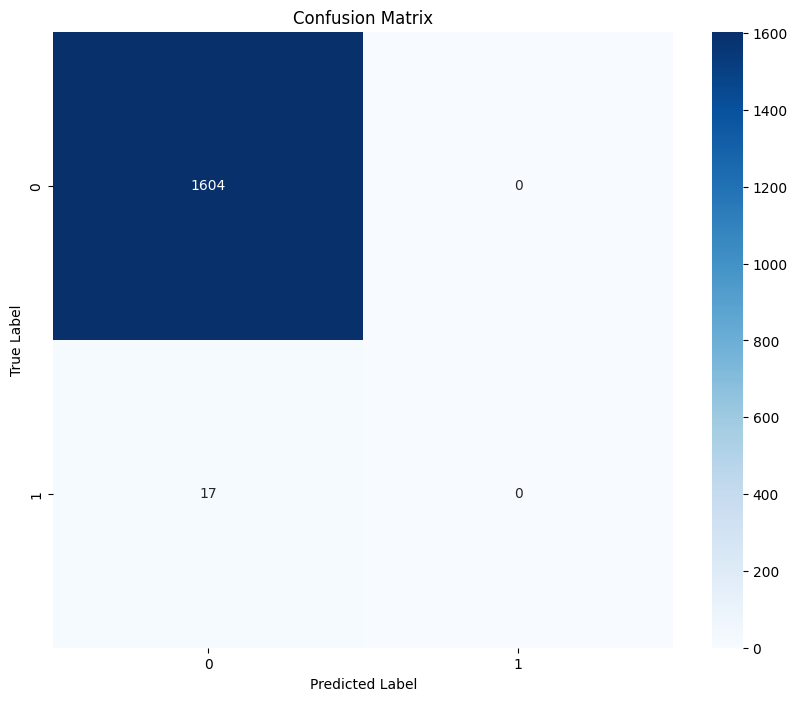

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    model_0.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model_0(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing Loop
model_0.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model_0(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
outputs = model_0(img)

In [ ]:
outputs.data

tensor([[ 3.1055, -3.0664],
        [ 2.7762, -2.7348],
        [ 2.7802, -2.7450],
        [ 3.0997, -3.0584],
        [ 2.7610, -2.7250],
        [ 2.5595, -2.5314],
        [ 2.9413, -2.8994],
        [ 2.9828, -2.9438],
        [ 2.7057, -2.6620],
        [ 2.8253, -2.7865],
        [ 2.9034, -2.8587],
        [ 3.0791, -3.0331],
        [ 2.9847, -2.9455],
        [ 3.3531, -3.3085],
        [ 2.6431, -2.6021],
        [ 3.8093, -3.7500],
        [ 3.3314, -3.2857],
        [ 3.0373, -2.9919],
        [ 3.2711, -3.2258],
        [ 2.9541, -2.9114],
        [ 2.8285, -2.7977],
        [ 3.5566, -3.4932],
        [ 2.9679, -2.9275],
        [ 3.1559, -3.1170],
        [ 3.1351, -3.1088],
        [ 3.1304, -3.0779],
        [ 3.1915, -3.1494],
        [ 2.9824, -2.9294],
        [ 3.3021, -3.2589],
        [ 3.0764, -3.0350],
        [ 3.0220, -2.9782],
        [ 3.7915, -3.7336]])